In [108]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pyh5md
from transforms3d import quaternions
from transforms3d.utils import normalized_vector
import scipy.integrate
import itertools
import tidynamics
from glob import glob
from matplotlib.figure import SubplotParams
import os.path

π = np.pi

plt.rcParams['figure.figsize'] = (8*.7, 6*.7)
plt.rcParams['figure.subplot.hspace'] = .25
plt.rcParams['figure.subplot.wspace'] = .3
plt.rcParams['figure.subplot.left'] = .24
plt.rcParams['figure.subplot.bottom'] = .15
plt.rcParams['figure.subplot.top'] = 0.95
plt.rcParams['figure.subplot.right'] = 0.95

plt.rcParams['font.size'] = 12


In [278]:
TYPE = 'h'

In [135]:
# bead indices defining directions "1" and "2"

idx_1, idx_2 = 5, 33

runs = glob('/home/share/nanomotors/20190[45]*/lpart_*/lpart_2019_nosp_noh.h5')
runs.sort()

if TYPE == 'h':
    runs = glob('/home/share/nanomotors/20190[45]*/lpart_2*/lpart_2019_nosp.h5')
else:
    runs = glob('/home/share/nanomotors/20190[45]*/lpart_2*/lpart_2019_nosp_noh.h5')
    
runs.sort()
print(len(runs), "runs found")

20 runs found


In [136]:
runs

['/home/share/nanomotors/20190417/lpart_21087167/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190417/lpart_21087168/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190417/lpart_21087169/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190417/lpart_21087170/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190417/lpart_21087171/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190417/lpart_21087172/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190429/lpart_21097760/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190429/lpart_21097761/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190429/lpart_21097762/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190429/lpart_21097763/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190429/lpart_21097764/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190429/lpart_21097765/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190505/lpart_21100255/lpart_2019_nosp.h5',
 '/home/share/nanomotors/20190505/lpart_21100256/lpart_2019_nosp.h5',
 '/home/share/nanomo

## Read and analyze simulation data

For every simulation:
1. Compute the "body frame" velocity vB of the L particle
2. Integrate vB to obtain the "body frame" trajectory
3. Compute the cross-displacements and fit the slope to obtain the diffusion matrix

Run the cell below onces with `custom_TP = False`, obtain d1 and d2, then re-run
with `custom_TP = True`.

In [292]:


custom_TP = True
if custom_TP:
    delta_pos = np.array([d1, d2, 0])
else:
    delta_pos = np.zeros(3)

all_cdisp = []
all_coh_pos = []
v_mean = []
all_skip = 2
comh_vacf = []

u_check = []

for r in runs[:]:
    try:
        tmp_try = pyh5md.File(r, 'r')
    except:
        continue
    with pyh5md.File(r, 'r') as a:
        #if a['parameters/probability'][()] != 0.: continue
        #if a['parameters/do_hydro'][()] != 1: continue
        print(r)
        L = a['particles/janus/box/edges'][:]

        g = a.particles_group('janus')
        el = pyh5md.element(g, 'position')
        pos_dt = el.time
        pos = el.value[:]
        el = pyh5md.element(g, 'image')
        im = el.value[:]
        im_dt = el.time
        pos += im*L
        pos_0 = pos[0,:,:]

        obs = a['observables']
        janus_pos = pyh5md.element(obs, 'janus_pos')
        janus_pos_dt = janus_pos.time*all_skip
        janus_pos = janus_pos.value[::all_skip]
        janus_vel = pyh5md.element(obs, 'janus_vel')
        janus_vel_dt = janus_vel.time*all_skip
        janus_vel = janus_vel.value[::all_skip]
        omega_body = pyh5md.element(obs, 'omega_body')
        omega_body_dt = omega_body.time*all_skip
        omega_body = omega_body.value[::all_skip]
        q = pyh5md.element(obs, 'q')
        q_qt = q.time*all_skip
        q = q.value[::all_skip]
        u = pyh5md.element(obs, 'u')
        u_dt = u.time*all_skip
        u = u.value[::all_skip]

    tmp_s = q[:,3].copy()
    tmp_v = q[:,:3].copy()
    q[:,1:4] = tmp_v
    q[:,0] = tmp_s
    del tmp_s, tmp_v

    omega = np.array([quaternions.rotate_vector(omega_body_i, q_i) for omega_body_i, q_i in zip(omega_body, q)])

    # Compute the basis vectors for the L at initial data point

    if custom_TP:
        basis_u_perp = normalized_vector(pos_0[idx_2] - pos_0[0])
        basis_u_para = normalized_vector(pos_0[idx_1] - pos_0[0])

        q_0_inv_mat = quaternions.quat2mat(quaternions.qinverse(q[0]))

        basis_u_perp = q_0_inv_mat @ basis_u_perp
        basis_u_para = q_0_inv_mat @ basis_u_para

        # Compute the trajectory of the CoH based on the CoM data
        coh_pos = []
        for i in range(u.shape[0]):
            shift_para = quaternions.quat2mat(q[i]) @ basis_u_para
            shift_perp = quaternions.quat2mat(q[i]) @ basis_u_perp
            coh_pos.append(janus_pos[i] + d1*shift_para + d2*shift_perp)

        all_coh_pos.append(np.array(coh_pos))
    
    d_20_0 = np.sqrt(np.sum((pos_0[idx_2]-pos_0[0])**2))
    d_4_0 = np.sqrt(np.sum((pos_0[idx_1]-pos_0[0])**2))
    u_perp = (pos_0[idx_2,:]-pos_0[0,:])/d_20_0
    u_para = (pos_0[idx_1,:]-pos_0[0,:])/d_4_0

    u_perp = np.array([quaternions.rotate_vector(u_perp, q_i) for q_i in q])
    u_para = np.array([quaternions.rotate_vector(u_para, q_i) for q_i in q])

    u_check.append(np.einsum('...i,...i', u_perp, u_para))

    v1 = np.array([np.dot(v, u1) for v, u1 in zip(janus_vel, u_para)])
    v2 = np.array([np.dot(v, u2) for v, u2 in zip(janus_vel, u_perp)])

    if custom_TP:
        v_rel = np.cross(omega_body, delta_pos[None,:])

        v1 += v_rel[:,0]
        v2 += v_rel[:,1]
        
    comh_vacf.append(tidynamics.acf(v1)+tidynamics.acf(v2))
    
    disp1 = scipy.integrate.cumtrapz(v1)*janus_vel_dt
    disp2 = scipy.integrate.cumtrapz(v2)*janus_vel_dt
    dispt = scipy.integrate.cumtrapz(omega[:,2])*omega_body_dt

    disp_stride = 32
    disp1 = disp1[::disp_stride]
    disp2 = disp2[::disp_stride]
    dispt = dispt[::disp_stride]

    xyz = np.array(list(zip(disp1, disp2, dispt)))
    cdisp = tidynamics.cross_displacement(xyz)

    all_cdisp.append(cdisp)

    v_mean.append((v1.mean(), v2.mean(), omega[:,2].mean()))

comh_vacf = np.array(comh_vacf)
v_mean = np.array(v_mean)

if custom_TP:
    cdisp_cus = all_cdisp.copy()
else:
    cdisp_com = all_cdisp.copy()

/home/share/nanomotors/20190417/lpart_21087167/lpart_2019_nosp.h5
/home/share/nanomotors/20190417/lpart_21087168/lpart_2019_nosp.h5
/home/share/nanomotors/20190417/lpart_21087169/lpart_2019_nosp.h5
/home/share/nanomotors/20190417/lpart_21087170/lpart_2019_nosp.h5
/home/share/nanomotors/20190417/lpart_21087171/lpart_2019_nosp.h5
/home/share/nanomotors/20190417/lpart_21087172/lpart_2019_nosp.h5
/home/share/nanomotors/20190429/lpart_21097760/lpart_2019_nosp.h5
/home/share/nanomotors/20190429/lpart_21097761/lpart_2019_nosp.h5
/home/share/nanomotors/20190429/lpart_21097762/lpart_2019_nosp.h5
/home/share/nanomotors/20190429/lpart_21097763/lpart_2019_nosp.h5
/home/share/nanomotors/20190429/lpart_21097764/lpart_2019_nosp.h5
/home/share/nanomotors/20190429/lpart_21097765/lpart_2019_nosp.h5
/home/share/nanomotors/20190505/lpart_21100255/lpart_2019_nosp.h5
/home/share/nanomotors/20190505/lpart_21100256/lpart_2019_nosp.h5
/home/share/nanomotors/20190505/lpart_21100257/lpart_2019_nosp.h5
/home/shar

In [121]:
len(runs)

20

<IPython.core.display.Javascript object>


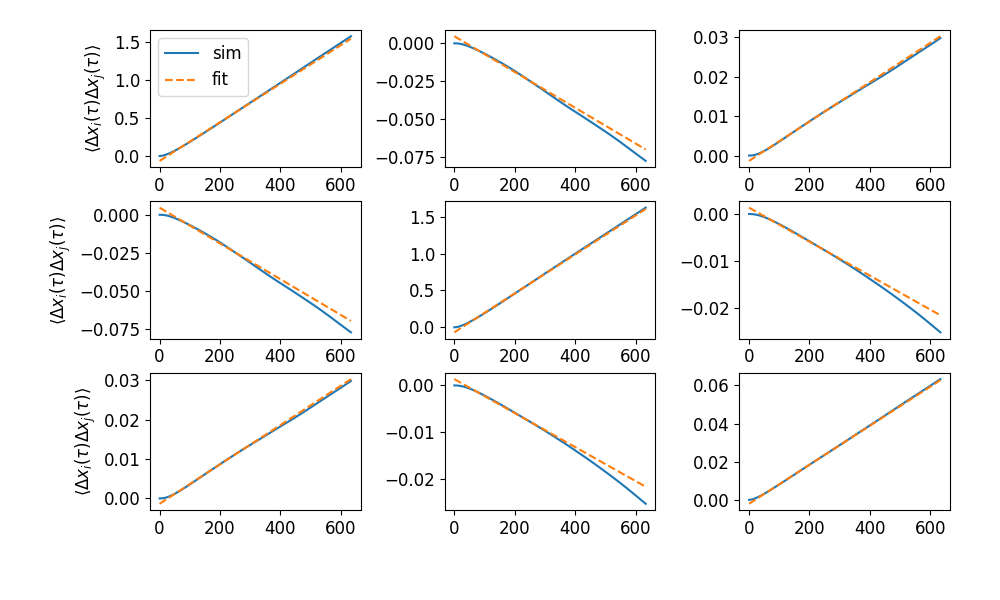

In [290]:
START, STOP = 5, 50

N_disp = 100

disp_time = np.arange(N_disp)*janus_vel_dt*disp_stride

cd = np.mean(cdisp_com, axis=0)
Ddata = np.zeros((3,3))

params = SubplotParams(wspace=0.40, left=.15)
plt.figure(figsize=(10, 6), subplotpars=params)

for i, j in itertools.product(range(3), range(3)):
    plt.subplot(3, 3, 3*i+j+1)

    m = cd[i][j]
    plt.plot(disp_time, m[:N_disp], label='sim')
    fit = np.polyfit(disp_time[START:STOP], m[START:STOP], 1)
    plt.plot(disp_time, np.poly1d(fit)(disp_time), label='fit', ls='--')

    if i==j==0:
        plt.legend()
    Ddata[i, j] = fit[-2]/2

    if j==0:
        plt.ylabel(r'$\langle \Delta x_i(\tau) \Delta x_j(\tau) \rangle$')


In [291]:
d1, d2 = -Ddata[1,2]/Ddata[2,2], Ddata[0,2]/Ddata[2,2]

print("Correction from CoM to CoH - from Chakrabarty et al 2014, Eq. 33")
print(d1, d2)

Correction from CoM to CoH - from Chakrabarty et al 2014, Eq. 33
0.35481791912132477 0.48831794686816077


In [285]:
d1, d2 = -Ddata[1,2]/Ddata[2,2], Ddata[0,2]/Ddata[2,2]

print("Correction from CoM to CoH - from Chakrabarty et al 2014, Eq. 33")
print(d1, d2)

Correction from CoM to CoH - from Chakrabarty et al 2014, Eq. 33
0.5901373893548949 0.46167031912155465


In [151]:
np.array([20, 240]) / (disp_stride*janus_vel_dt)

array([ 3.125, 37.5  ])

<IPython.core.display.Javascript object>


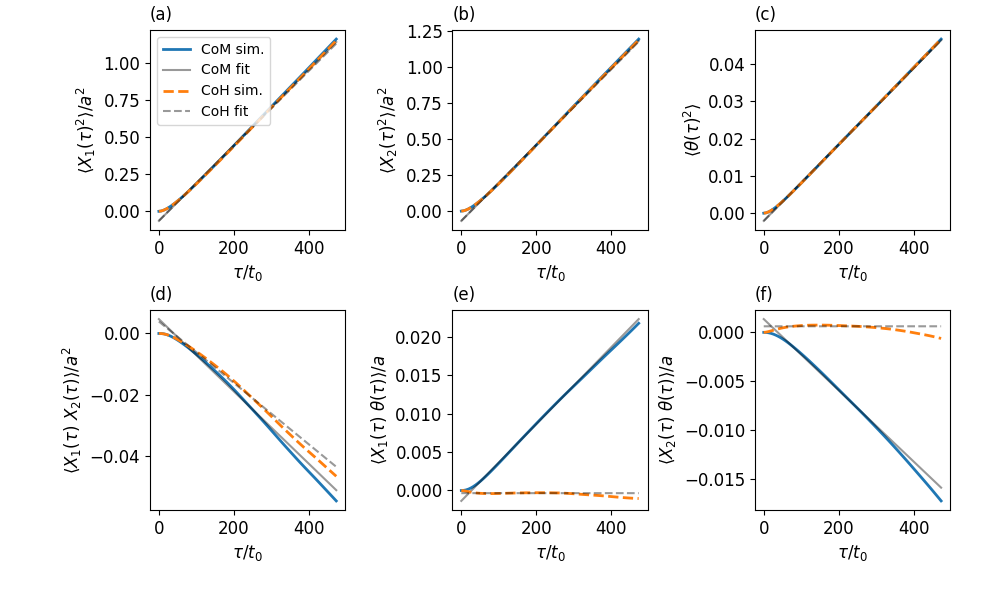

In [293]:
START, STOP = 5, 50

N_disp = 75

disp_time = np.arange(N_disp)*janus_vel_dt*disp_stride

cd_com = np.mean(cdisp_com, axis=0)
cd_cus = np.mean(cdisp_cus, axis=0)
D_com = np.zeros((3,3))
D_cus = np.zeros((3,3))

idx_list = [(0,0), (1, 1), (2, 2), (0, 1), (0, 2), (1, 2)]
label_list = [r'$\langle X_1(\tau)^2 \rangle / a^2$',
              r'$\langle X_2(\tau)^2 \rangle / a^2$',
              r'$\langle \theta(\tau)^2 \rangle$',
              r'$\langle X_1(\tau)\ X_2(\tau) \rangle / a^2$',
              r'$\langle X_1(\tau)\ \theta(\tau) \rangle / a$',
              r'$\langle X_2(\tau)\ \theta(\tau) \rangle / a$',
             ]
letter_list = 'abcdef'

params = SubplotParams(wspace=0.55, left=.15, hspace=0.4)
fig = plt.figure(figsize=(10, 6), subplotpars=params)


subplot_idx = 0
for i, j in idx_list:
    subplot_idx += 1
    ax = plt.subplot(2, 3, subplot_idx)

    m = cd_com[i][j]
    plt.plot(disp_time, m[:N_disp], label='CoM sim.', ls='-', lw=2)
    fit = np.polyfit(disp_time[START:STOP], m[START:STOP], 1)
    plt.plot(disp_time, np.poly1d(fit)(disp_time), label='CoM fit', ls='-', alpha=0.4, color='k')
    D_com[i, j] = D_com[j, i] = fit[-2]/2

    m = cd_cus[i][j]
    plt.plot(disp_time, m[:N_disp], label='CoH sim.', ls='--', lw=2)
    fit = np.polyfit(disp_time[START:STOP], m[START:STOP], 1)
    plt.plot(disp_time, np.poly1d(fit)(disp_time), label='CoH fit', ls='--', alpha=0.4, color='k')
    D_cus[i, j] = D_cus[j, i] = fit[-2]/2

    if subplot_idx==1:
        plt.legend(fontsize=10)
    plt.text(0., 1.05, '('+letter_list[subplot_idx-1]+')', transform=ax.transAxes)

    plt.xlabel(r'$\tau / {t_0} $')
    plt.ylabel(label_list[subplot_idx-1])

#plt.savefig('L_eq_cdisp.pdf')

In [271]:
# print D_com with LaTeX table formatting
for line in D_com:
    l1, l2, l3 = map(lambda x: 10000*x, line)
    
    print('%3.2f & %3.2f & %3.2f \\cr' % (l1, l2, l3))


12.70 & -0.59 & 0.25 \cr
-0.59 & 13.20 & -0.18 \cr
0.25 & -0.18 & 0.51 \cr


In [270]:
# print D_cus with LaTeX table formatting
for line in D_cus:
    l1, l2, l3 = map(lambda x: 10000*x, line)
    
    print('%3.2f & %3.2f & %3.2f \\cr' % (l1, l2, l3))


12.58 & -0.50 & -0.00 \cr
-0.50 & 13.13 & 0.00 \cr
-0.00 & 0.00 & 0.51 \cr


In [255]:
l, d1, D_cus, D_cus[1,1] / (D_cus[2,2]*l), d1, d2

(0.48,
 0.35481791912132477,
 array([[ 1.25760062e-03, -5.00282852e-05, -1.96677692e-09],
        [-5.00282852e-05,  1.31310931e-03,  1.42908468e-09],
        [-1.96677692e-09,  1.42908468e-09,  5.11779636e-05]]),
 53.45356081267256,
 0.35481791912132477,
 0.48831794686816077)

In [241]:
σ = 1.5

In [281]:
# Coordinates: x=0 is the bottom-left corner of the L

# center of mass of the L
x_com = ( 9 * (0 + 1 + 2) + 3 * (3 + 4 + 5) ) * σ / 36

# center of the foot of the L
x_mid = (0 + 1 + 2 + 3 + 4 + 5) * σ / 6

# position of the center of hydrodynamics
x_coh = x_com + d1

l = x_mid - x_coh
print('l = ', l)


l =  0.5543528189679803


In [277]:
d1

0.35481791912132477

In [275]:
# Compute radius from force and torque
X_dot = D_cus @ np.array([0, 1, -l])
print(X_dot)
print(l, np.sqrt(X_dot[0]**2+X_dot[1]**2)/X_dot[2])


[-5.00267704e-05  1.31310821e-03 -3.94149214e-05]
0.7701820808786755 -33.339171385887724


<IPython.core.display.Javascript object>


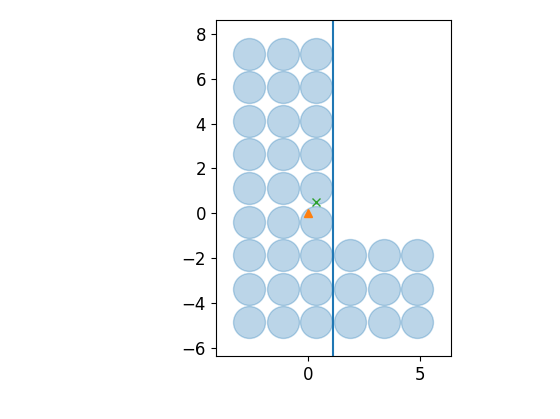

(-6.375005192649612, 8.625002679169022)

In [250]:
plt.figure()
plt.subplot(111, aspect=1)

TH_0 = np.arctan2(pos_0[33,1]-pos_0[0,1], pos_0[33,0]-pos_0[0,0])
TH_0 = π/2 - TH_0

rot_m = np.array([[np.cos(TH_0), -np.sin(TH_0)], [np.sin(TH_0), np.cos(TH_0)]])

xy = pos_0[:36,:2]

xy -= xy.mean(axis=0)
xy = np.array([rot_m @ i for i in xy])


plt.plot(*xy.T, ls='', marker='o', ms=23, alpha=0.3)
plt.plot([0], [0], ls='', marker='^')
plt.plot([d1], [d2], ls='', marker='x')

plt.axvline(xy[:6,0].mean())

plt.xlim(xy[:,0].min()-σ, xy[:,0].max()+σ)
plt.ylim(xy[:,1].min()-σ, xy[:,1].max()+σ)